<a href="https://colab.research.google.com/github/minhhuy243/seam-carving/blob/master/Seam_Carving_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/minhhuy243/seam-carving.git
%cd ./seam-carving

Cloning into 'seam-carving'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 101 (delta 34), reused 80 (delta 16), pack-reused 0
Receiving objects: 100% (101/101), 3.21 MiB | 2.75 MiB/s, done.
Resolving deltas: 100% (34/34), done.
/content/seam-carving


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from PIL import Image
import numpy as np
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  
  return Image.fromarray(pixels)

# Báo cáo Đồ án Lập trình song song trên GPU
- Thông tin nhóm
  - Nguyễn Ngọc Đức - 21424007
  - Phan Phi Hùng - 21424023
  - Lưu Minh Huy - 21424026
- Github: https://github.com/minhhuy243/seam-carving

## 1. Mô tả ứng dụng
- **Ứng dụng**: **Thay đổi kích thước ảnh bằng thuật toán Seam Carving (ở đồ án này chỉ thu hẹp chiều rộng)**
    - Input: một tấm ảnh (RGB).
    - Output: một tấm ảnh mới được thay đổi kích thước từ tấm ảnh gốc mà không làm biến dạng các đối tượng quan trọng.
- **Ý nghĩa thực tế khi sử dụng?**
    - Khi muốn có các phiên bản với các kích thước khác nhau của cùng một tấm ảnh để hiển thị trên các thiết bị khác nhau (máy tính, điện thoại, ...).
   - Một ví dụ thực tế khi tạo thumbnail (ảnh đại diện) cho 1 video chúng ta sẽ dựa vào nhưng yếu tố khác để resize ảnh về đúng khung hình ta mong muốn như màn hình điện thoại 16:9 , 3:4.


## 2. Cài đặt tuần tự

![](https://github.com/minhhuy243/seam-carving/blob/master/report/flowchart.png?raw=1)

#### 2.1. Mô tả các bước triển khai:
- **1. Chuyển ảnh từ RGB sang Grayscale.**
- **2. Tính bảng Energy.**
- **3. Tìm bảng chi phí nhỏ nhất.**
    - Sử dụng Dynamic Programming để xây dựng bảng chi phí nhỏ nhất
        - Ở hàng trên cùng ta có tổng chi phí giữ nguyên. Với các hàng còn lại, chi phí của mỗi pixel bằng engergy của nó cộng với chi phí nhỏ nhất của 3 pixel liền kề phía trên. <br/>
        ![](https://github.com/minhhuy243/seam-carving/blob/master/report/algo1.png?raw=1)<br/>
        > Nguồn ảnh: https://github.com/kalpeshdusane/Seam-Carving-B.E.-Project
        - Lặp lại quá trình cho đến hàng cuối cùng ta được bảng chi phí nhỏ nhất. <br/>
        ![](https://github.com/minhhuy243/seam-carving/blob/master/report/algo2.png?raw=1)
        > Nguồn ảnh: https://github.com/kalpeshdusane/Seam-Carving-B.E.-Project
- **4. Tìm Seam nhỏ nhất (truy từ dưới lên trên)**
    - Từ bảng chi phí nhỏ nhất trên ta xác định được vị trí có tổng chi phí nhỏ nhất ở hàng cuối cùng và quay lui để xác định Seam nhỏ nhất<br/>
    ![](https://github.com/minhhuy243/seam-carving/blob/master/report/algo3.png?raw=1)
    > Nguồn ảnh: https://github.com/kalpeshdusane/Seam-Carving-B.E.-Project
- **5. Xóa Seam nhỏ nhất đã tìm được từ bước 4.**
- **6. Lặp lại từ bước 2 -> 5 cho đến khi đạt được số Seam mong muốn.**

#### 2.2. Ý tưởng cải tiến
....

#### 2.3. Demo


In [ ]:
!nvcc ./src/host.cu -o ./src/host

In [ ]:
!./src/host ./images/broadcast_tower.pnm .\output/broadcast_tower.pnm 150

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 274 x 186

Number of seam removed: 150

Processing time (use host): 572.933960 ms

Processing time (use host has been optimized): 104.286942 ms

Error between: 0.000000


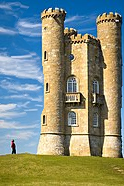

In [ ]:
show_pnm('./output/broadcast_tower_host.pnm')

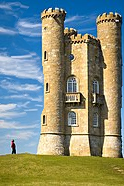

In [ ]:
show_pnm('./output/broadcast_tower_host_optimized.pnm')

## 3. Cài đặt song song

#### 3.1. Chọn các chức năng sẽ được song song và tối ưu hoá

##### 3.1.1. Chuyển ảnh từ RGB sang Grayscale trên hàm Kernel
- Mỗi Thread sẽ đảm nhận tính kết quả grayscale cho mỗi pixel của ảnh.

##### 3.1.2 Tính bảng Energy trên hàm Kernel
- Mỗi Thread sẽ đảm nhận tính energy cho mỗi pixel của ảnh. 
- Sử dụng SMEM để giảm truy xuất GMEM, từ đó tăng tốc độ tính toán (tối ưu hóa).

##### 3.1.3. Tính bảng chi phí nhỏ nhất trên hàm Kernel
- Vì chi phí nhỏ nhất của mỗi pixel sẽ được tính bằng cách cộng thêm chi phí nhỏ nhất của 1 trong 3 pixel liền kề của dòng phía trên, nên ta có thể song song hoá việc tính chi phí theo từng dòng.
- Trong hàm Kernel này thì việc tính bảng chi phí sẽ được tính trên mỗi dòng, sau đó các Thread được tạo sẽ đảm nhận tính chi phí cho mỗi pixel của dòng đó.

##### 3.1.4. Xóa Seam nhỏ nhất trên hàm Kernel
- Bản chất của xóa seam là dịch các pixel bên phải sang bên trái để lắp đầy các khoảng trống của mỗi dòng trên ảnh, do đó các phép gán có thể thực hiện độc lập trên từng Thread.
- Mỗi Thread sẽ đảm nhận việc xóa một pixel trên mỗi dòng của Seam nhỏ nhất đã được tìm thấy trước đó.


#### 3.2. Demo

In [ ]:
!nvcc ./src/device.cu -o ./src/device

- Cat

In [ ]:
!./src/device ./images/cat.pnm .\output/cat.pnm 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 240 x 320

Number of seam removed: 100

Processing time (use host has been optimized): 101.191391 ms

Processing time (use device): 61.934654 ms

Error between device result and host result: 0.000000


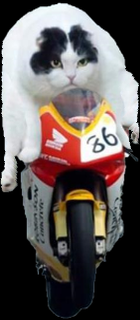

In [ ]:
show_pnm('./output/cat_host.pnm')

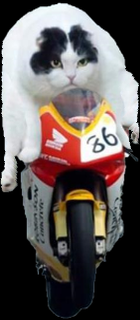

In [ ]:
show_pnm('./output/cat_device.pnm')

- Elephant

In [ ]:
!./src/device ./images/elephant.pnm .\output/elephant.pnm 350

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 787 x 444

Number of seam removed: 350

Processing time (use host has been optimized): 1551.599365 ms

Processing time (use device): 417.825165 ms

Error between device result and host result: 0.000000


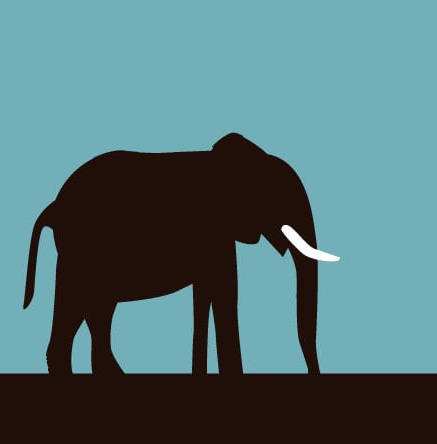

In [ ]:
show_pnm('./output/elephant_host.pnm')

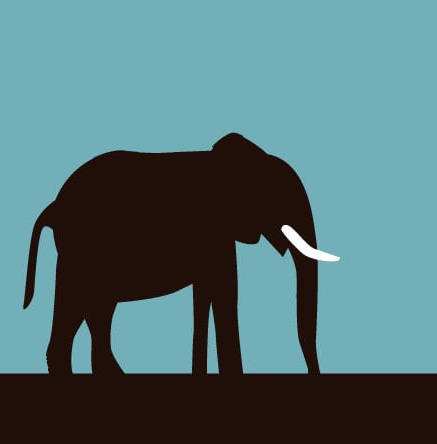

In [ ]:
show_pnm('./output/elephant_device.pnm')

- Clock

In [ ]:
!./src/device ./images/clock.pnm .\output/clock.pnm 400

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 788 x 599

Number of seam removed: 400

Processing time (use host has been optimized): 2474.420166 ms

Processing time (use device): 531.502258 ms

Error between device result and host result: 2.173034


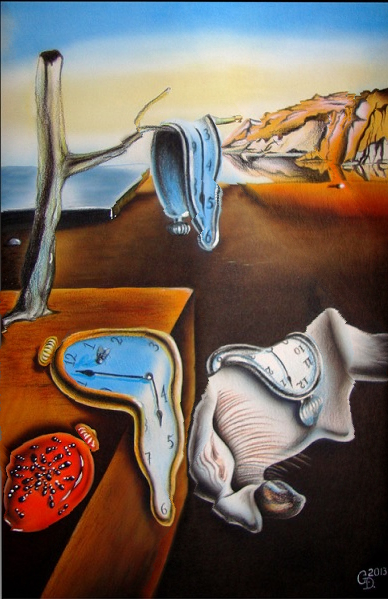

In [ ]:
show_pnm('./output/clock_host.pnm')

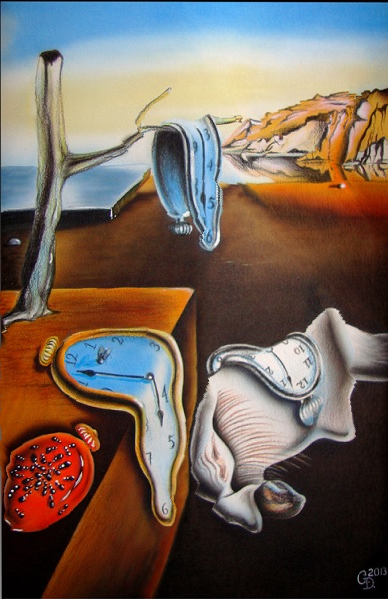

In [ ]:
show_pnm('./output/clock_device.pnm')

## 4. Những điểm chưa đạt được

## 5. Tài liệu tham khảo
- https://vnoi.info/wiki/cs/imageprocessing/Seam-Carving.md
- https://github.com/kalpeshdusane/Seam-Carving-B.E.-Project
- https://shwestrick.github.io/2020/07/29/seam-carve.html